In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1011. Emission Mixtures/P1011.3. Analyses/P1011.3.1. Data Processing/Output')
cur_date = "090423"

library(readxl)
library(openxlsx)
library(tidyverse)
library(reshape2)
library(imputeLCMD)
library(data.table)
library(factoextra)
library(ggrepel)
library(pheatmap)
#library(RUVSeq)
#library(vsn)

# reading in file
mRNA_df = data.frame(read_excel("Input/mRNA_Data_041423.xlsx", sheet = 2)) %>%
    rename(Dose = Concentration) %>%
    # only interested in doses 1, 25, and control, time point of 24 hrs
    filter(Dose %in% c(1,25,NA), Time_Point == 24) %>%
    select(-Time_Point)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: tmvtnorm

Loading required package: mvtnorm

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: stats4

Loading required package: gmm

Loading required package: sandwich

Loading required package: norm

This package has some ma

In [2]:
head(mRNA_df)

,Subject_No,Subject_ID,mRNA,Condensate,Burn_Condition,Dose,ddCT,ddCT_pslog2
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,1,F_1,ALDH1A3,C,F,1,-6.6824749,4.480105
2,2,M_2,ALDH1A3,C,F,1,0.2560009,4.870661
3,3,M_3,ALDH1A3,C,F,1,0.4318636,4.879307
4,4,F_4,ALDH1A3,C,F,1,0.4193253,4.878692
5,6,M_6,ALDH1A3,C,F,1,-0.1550695,4.850246
6,2,M_2,ALDH1A3,C,S,1,-0.3182245,4.842062


In [3]:
# checking for duplicates
Dups = duplicated(mRNA_df)
summary(Dups)

   Mode   FALSE 
logical     872 

In [4]:
# # doing some initial data formatting
# wider_cytokine_df = cytokine_df %>%
#     rename(Dose = Condensate_Conc) %>%
#     # only interested in doses 1 and 25
#     filter(Dose %in% c(1,25))
#     # creating sample ids
#     unite("SampleID", c(colnames(cytokine_df)[c(1,3:5)]), sep = "_") %>%
#     select(-c("Cytokine_Conc_pslog2", "Subject_ID")) %>%
#     pivot_wider(names_from = "SampleID", values_from = "Cytokine_Conc") %>%
#     column_to_rownames(var = "Cytokine")

No duplicates. Now creating dataframes that are formatted for proceeding code, as well as DESeq2 functions. FOR NOW ONLY DOING THIS FOR DOSE 1UG/ML!!!!!!!

In [5]:
# first creating a `coldata` object that contains all the metadata for each sample
coldata = unique(mRNA_df[,c(1,2,4:6)]) %>%
    filter(Dose %in% c(1,NA)) %>%
    select(-Dose) %>%
    # creating sample ids
    unite("SampleID", c(colnames(mRNA_df))[c(1,4,5)], sep = "_", remove = FALSE)

head(coldata)

,SampleID,Subject_No,Subject_ID,Condensate,Burn_Condition
,<chr>,<dbl>,<chr>,<chr>,<chr>
1,1_C_F,1,F_1,C,F
2,2_C_F,2,M_2,C,F
3,3_C_F,3,M_3,C,F
4,4_C_F,4,F_4,C,F
5,6_C_F,6,M_6,C,F
6,2_C_S,2,M_2,C,S


In [6]:
# making a `countdata` obj that contains mRNAs as rows and sample names as cols
countdata = mRNA_df %>%
    filter(Dose %in% c(1,NA)) %>%
    select(-Dose) %>%
    # creating sample ids
    unite("SampleID", c(colnames(mRNA_df)[c(1,4,5)]), sep = "_") %>%
    select(-c("ddCT_pslog2", "Subject_ID")) %>%
    # taking average of some samples with replicates
    group_by(SampleID, mRNA) %>%
    summarize(ddCT = mean(ddCT)) %>%
    pivot_wider(names_from = "SampleID", values_from = "ddCT") %>%
    column_to_rownames(var = "mRNA")

head(countdata)

`summarise()` has grouped output by 'SampleID'. You can override using the
`.groups` argument.


,1_C_F,1_C_S,1_P_F,1_P_S,2_C_F,2_C_S,2_P_F,2_P_S,3_C_F,3_C_S,⋯,4_P_F,4_P_S,5_C_F,5_C_S,5_P_F,5_P_S,6_C_F,6_C_S,6_P_F,6_P_S
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALDH1A3,-6.68247492,NA,-0.2508904,0.9715878,0.2560009,-0.3182245,-0.5576900,0.8243979,0.4318636,0.24096646,⋯,-0.8721998,0.5247155,NA,0.9049820,0.4239748,-0.30781430,-0.1550695,1.171415,0.2800502,-0.2117398
ALDH3A1,-3.66574480,0.4982387,0.3331193,-0.3155339,0.4862897,0.1133608,-0.4219950,0.9372704,0.5286367,0.07784354,⋯,0.9869043,NA,0.4459567,0.7561709,1.6230304,-0.55571215,NA,1.314235,NA,-0.5870436
CXCL1,0.94993682,-0.1058011,0.3844082,1.1944874,0.3703021,-0.9091016,-0.4487040,-0.5657312,0.7542026,-1.16230376,⋯,0.2025795,NA,-0.5811714,1.2832163,0.2574131,0.05955717,NA,-5.820969,NA,0.1601361
CXCR1,-13.54739844,-15.5025570,-11.4947959,-12.7833618,-13.5183708,-13.1291145,-13.3027969,-13.3124113,-12.8308465,-14.17315349,⋯,-12.3707796,NA,-13.1482028,-12.1842584,-12.2044963,-12.83029610,NA,-15.053436,NA,-13.2772275
CYP1A1,0.02626103,NA,0.0891136,3.7032160,0.1250876,3.1602150,0.6678367,3.5275117,1.0696742,4.63996160,⋯,-0.2759376,5.4293462,NA,3.9757913,-0.5672375,4.22370940,0.7072530,3.735835,0.6936282,4.7865400
CYP1B1,0.18844003,NA,-0.5205214,1.5415030,0.6932902,1.3184236,0.4043986,2.0450932,0.5260385,1.77289004,⋯,-0.8755115,1.7828070,NA,1.0024558,-0.5655470,0.75147256,0.4829555,1.661537,0.1723445,1.4214741


In [7]:
# checking for duplicates
summary(duplicated(coldata))
summary(duplicated(countdata))

# getting dimensions
dim(coldata)
dim(countdata)

   Mode   FALSE 
logical      24 

   Mode   FALSE 
logical      19 

[1] 24  5

[1] 19 24

In [8]:
# Set the rownames of coldata and column names of countdata to be in the same order 
countdata <- setcolorder(countdata, as.character(coldata$SampleID))

# replacing the sample ids in the countdata file with the ids
#colnames(countdata) <- coldata$ID

head(countdata)

,1_C_F,2_C_F,3_C_F,4_C_F,6_C_F,2_C_S,3_C_S,4_C_S,5_C_S,6_C_S,⋯,5_P_F,6_P_F,1_P_S,2_P_S,3_P_S,4_P_S,5_P_S,6_P_S,5_C_F,1_C_S
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALDH1A3,-6.68247492,0.2560009,0.4318636,0.4193253,-0.1550695,-0.3182245,0.24096646,0.116019,0.9049820,1.171415,⋯,0.4239748,0.2800502,0.9715878,0.8243979,0.3741436,0.5247155,-0.30781430,-0.2117398,NA,NA
ALDH3A1,-3.66574480,0.4862897,0.5286367,0.4204990,NA,0.1133608,0.07784354,NA,0.7561709,1.314235,⋯,1.6230304,NA,-0.3155339,0.9372704,0.8890250,NA,-0.55571215,-0.5870436,0.4459567,0.4982387
CXCL1,0.94993682,0.3703021,0.7542026,0.2451099,NA,-0.9091016,-1.16230376,NA,1.2832163,-5.820969,⋯,0.2574131,NA,1.1944874,-0.5657312,0.6843359,NA,0.05955717,0.1601361,-0.5811714,-0.1058011
CXCR1,-13.54739844,-13.5183708,-12.8308465,-12.5098158,NA,-13.1291145,-14.17315349,NA,-12.1842584,-15.053436,⋯,-12.2044963,NA,-12.7833618,-13.3124113,-12.9683561,NA,-12.83029610,-13.2772275,-13.1482028,-15.5025570
CYP1A1,0.02626103,0.1250876,1.0696742,1.1992955,0.7072530,3.1602150,4.63996160,4.882642,3.9757913,3.735835,⋯,-0.5672375,0.6936282,3.7032160,3.5275117,4.5542575,5.4293462,4.22370940,4.7865400,NA,NA
CYP1B1,0.18844003,0.6932902,0.5260385,0.5569810,0.4829555,1.3184236,1.77289004,1.985805,1.0024558,1.661537,⋯,-0.5655470,0.1723445,1.5415030,2.0450932,1.4507656,1.7828070,0.75147256,1.4214741,NA,NA


In [9]:
# Double checking that the same variables appear between the two dataframes
setequal(as.character(coldata$SampleID), colnames(countdata))

# Additionally checking that not only the sets of variables are the same, but that they are in the same order
identical(as.character(coldata$SampleID), colnames(countdata))

[1] TRUE

[1] TRUE

In [11]:
countdata[,1:12]
countdata[,13:24]

,1_C_F,2_C_F,3_C_F,4_C_F,6_C_F,2_C_S,3_C_S,4_C_S,5_C_S,6_C_S,1_P_F,2_P_F
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALDH1A3,-6.68247492,0.256000947,0.4318636,0.41932532,-0.1550695,-0.31822448,0.240966463,0.116019,0.90498195,1.17141480,-0.25089035,-0.55768998
ALDH3A1,-3.66574480,0.486289654,0.5286367,0.42049897,NA,0.11336081,0.077843537,NA,0.75617091,1.31423544,0.33311935,-0.42199496
CXCL1,0.94993682,0.370302146,0.7542026,0.24510995,NA,-0.90910157,-1.162303758,NA,1.28321626,-5.82096891,0.38440816,-0.44870395
CXCR1,-13.54739844,-13.518370773,-12.8308465,-12.50981584,NA,-13.12911448,-14.173153487,NA,-12.18425845,-15.05343589,-11.49479592,-13.30279690
CYP1A1,0.02626103,0.125087584,1.0696742,1.19929547,0.7072530,3.16021504,4.639961600,4.882642,3.97579128,3.73583518,0.08911360,0.66783674
CYP1B1,0.18844003,0.693290234,0.5260385,0.55698096,0.4829555,1.31842357,1.772890035,1.985805,1.00245578,1.66153704,-0.52052136,0.40439865
GCLC,-0.41422956,-0.407260633,-0.2967134,-0.32212144,NA,-1.00294396,-1.259633764,NA,0.49715491,0.58217770,1.00765820,0.86669747
GCLM,0.53164500,-0.403732082,0.4463673,0.44575459,NA,-0.93438764,-1.246605884,NA,0.46427948,0.49887619,0.05120903,0.01479567
HMOX1,-0.73711255,0.004195910,-0.1994781,-0.13236527,NA,-0.18493250,-0.068183560,NA,-0.06169638,0.08827359,-0.59881572,-0.41783374


,3_P_F,4_P_F,5_P_F,6_P_F,1_P_S,2_P_S,3_P_S,4_P_S,5_P_S,6_P_S,5_C_F,1_C_S
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALDH1A3,0.22424325,-0.87219982,0.4239748,0.2800502,0.97158779,0.82439791,0.37414363,0.5247155,-0.30781430,-0.211739810,NA,NA
ALDH3A1,1.62376873,0.98690425,1.6230304,NA,-0.31553387,0.93727040,0.88902500,NA,-0.55571215,-0.587043636,0.44595667,0.49823867
CXCL1,-0.05186981,0.20257946,0.2574131,NA,1.19448740,-0.56573122,0.68433594,NA,0.05955717,0.160136144,-0.58117143,-0.10580108
CXCR1,-12.16252621,-12.37077955,-12.2044963,NA,-12.78336176,-13.31241132,-12.96835606,NA,-12.83029610,-13.277227458,-13.14820283,-15.50255697
CYP1A1,-0.07232453,-0.27593762,-0.5672375,0.6936282,3.70321600,3.52751170,4.55425750,5.4293462,4.22370940,4.786539978,NA,NA
CYP1B1,-0.94735143,-0.87551145,-0.5655470,0.1723445,1.54150298,2.04509315,1.45076561,1.7828070,0.75147256,1.421474121,NA,NA
GCLC,1.36355984,1.30078239,1.4121770,NA,0.61268659,1.27076390,1.46530480,NA,-1.07943256,-0.391085563,-0.63815136,-0.18779193
GCLM,0.55319984,0.22976812,0.8105078,NA,0.20067988,0.29117317,1.01634624,NA,0.03049407,0.002035925,-0.19769815,0.38630598
HMOX1,-0.49119279,-0.34369312,-0.4843426,NA,-0.29969963,-0.07500587,-0.22712636,NA,0.38999959,-0.298686713,-1.09699170,0.20821086


# QRILC Imputation
ADD MORE WORDS.

In [12]:
imputed_QRILC_object = impute.QRILC(countdata, tune.sigma = 0.1)
imputed_df = data.frame(imputed_QRILC_object[1]) #%>%
#     rownames_to_column(var = "mRNA") %>%
#     pivot_longer(cols = 2:24, names_to = "Sample_ID", values_to = "ddCT") %>%
#     separate(Sample_ID, into = c("Subject_No", "Condensate", "Burn_Condition", "Concentration", "Time_Point"))

# dataframes automatically add X to col names if it starts with a number so fixing that here
colnames(imputed_df) = colnames(countdata)

# # adding back in subject ids
# final_df = full_join(imputed_df, unique(avg_mRNA_df %>%
#                         select(c("Subject_No", "Subject_ID"))))

# # rearranging cols
# final_df = final_df[,c(2,8,1,3:7)]
head(imputed_df)

,1_C_F,2_C_F,3_C_F,4_C_F,6_C_F,2_C_S,3_C_S,4_C_S,5_C_S,6_C_S,⋯,5_P_F,6_P_F,1_P_S,2_P_S,3_P_S,4_P_S,5_P_S,6_P_S,5_C_F,1_C_S
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALDH1A3,-6.68247492,0.2560009,0.4318636,0.4193253,-0.1550695,-0.3182245,0.24096646,0.116019,0.9049820,1.171415,⋯,0.4239748,0.2800502,0.9715878,0.8243979,0.3741436,0.5247155,-0.30781430,-0.2117398,-6.7621542,-6.6330189
ALDH3A1,-3.66574480,0.4862897,0.5286367,0.4204990,-0.6248336,0.1133608,0.07784354,-3.281545,0.7561709,1.314235,⋯,1.6230304,-0.2827822,-0.3155339,0.9372704,0.8890250,-4.0289808,-0.55571215,-0.5870436,0.4459567,0.4982387
CXCL1,0.94993682,0.3703021,0.7542026,0.2451099,-0.6007715,-0.9091016,-1.16230376,-2.999119,1.2832163,-5.820969,⋯,0.2574131,-0.3571899,1.1944874,-0.5657312,0.6843359,-4.2168269,0.05955717,0.1601361,-0.5811714,-0.1058011
CXCR1,-13.54739844,-13.5183708,-12.8308465,-12.5098158,-0.6111608,-13.1291145,-14.17315349,-3.340283,-12.1842584,-15.053436,⋯,-12.2044963,-0.2899475,-12.7833618,-13.3124113,-12.9683561,-3.3600068,-12.83029610,-13.2772275,-13.1482028,-15.5025570
CYP1A1,0.02626103,0.1250876,1.0696742,1.1992955,0.7072530,3.1602150,4.63996160,4.882642,3.9757913,3.735835,⋯,-0.5672375,0.6936282,3.7032160,3.5275117,4.5542575,5.4293462,4.22370940,4.7865400,-6.8543921,-6.6653609
CYP1B1,0.18844003,0.6932902,0.5260385,0.5569810,0.4829555,1.3184236,1.77289004,1.985805,1.0024558,1.661537,⋯,-0.5655470,0.1723445,1.5415030,2.0450932,1.4507656,1.7828070,0.75147256,1.4214741,-6.7655435,-6.6630239


# Transcriptomics QA/QC 
Performed on raw count data to identify potential outlier samples. Starting by filtering lowly expressed cytokines.

In [13]:
countdata = imputed_df
# First count the total number of samples and save it as a value in the global environment
nsamp <- ncol(countdata)

# Then, calculate the median expression level across all genes and all samples and save it as a value
total_median <- median(as.matrix(countdata))

# We need to temporarily add back in the cytokine column to the countdata 
# so we can filter for genes that pass the background filter
countdata <- countdata %>% 
    rownames_to_column("mRNA")

In [14]:
# filtering for mRNAs that have an expression greater than the total median in at least 20% of the samples
mRNAs_above_background <- countdata %>% 
    pivot_longer(cols =! mRNA, names_to = "sampleID", values_to = "expression") %>% 
    # indicates whether the expression of a mRNA for the corresponding exposure condition is above (1) or not 
    # above (0) the median of all count data
    mutate(above_median = ifelse(expression > total_median,1,0)) %>% 
    group_by(mRNA) %>% 
    # For each mRNA, count the number of exposure conditions where the expression was greater than the median 
    # of all count data
    summarize(total_above_median = sum(above_median)) %>% 
    # Filter for mRNAs that have expression above the median in at least 20% of the samples
    filter(total_above_median >= 0.2*nsamp) %>% 
    select(mRNA) 

# Then filter the original 'countdata' dataframe for only the mRNAs above background. 
countdata <- left_join(mRNAs_above_background, countdata, by = "mRNA")

dim(countdata)

[1] 15 25

This dataframe went from having 19 mRNAs to 15 mRNAs. Now filtering samples with no expression. 

In [15]:
countdata_T <- countdata %>% 
  pivot_longer(cols =! mRNA, names_to = "sampleID",values_to = "expression") %>% 
  pivot_wider(names_from = mRNA, values_from = expression)

# Then add in a column to the transposed countdata dataframe that sums expression across all mRNAs for each 
# exposure condition
countdata_T$rowsum <- rowSums(countdata_T[2:ncol(countdata_T)])

# Remove samples that have no expression
countdata_T <- countdata_T %>% 
    filter(rowsum != 0)

# Take the count data filtered for correct samples, remove the 'rowsums' column
countdata_T <- countdata_T %>% 
    select(!rowsum) 

# Then, transpose it back to the correct format for analysis
countdata <- countdata_T %>%
  pivot_longer(cols =! sampleID, names_to = "mRNA", values_to = "expression") %>% 
  pivot_wider(names_from = sampleID, values_from = "expression") %>%
    column_to_rownames(var = "mRNA")

dim(countdata)

[1] 15 24

No samples were removed. Now finding and removing sample outliers using PCA and hierarchical clustering.

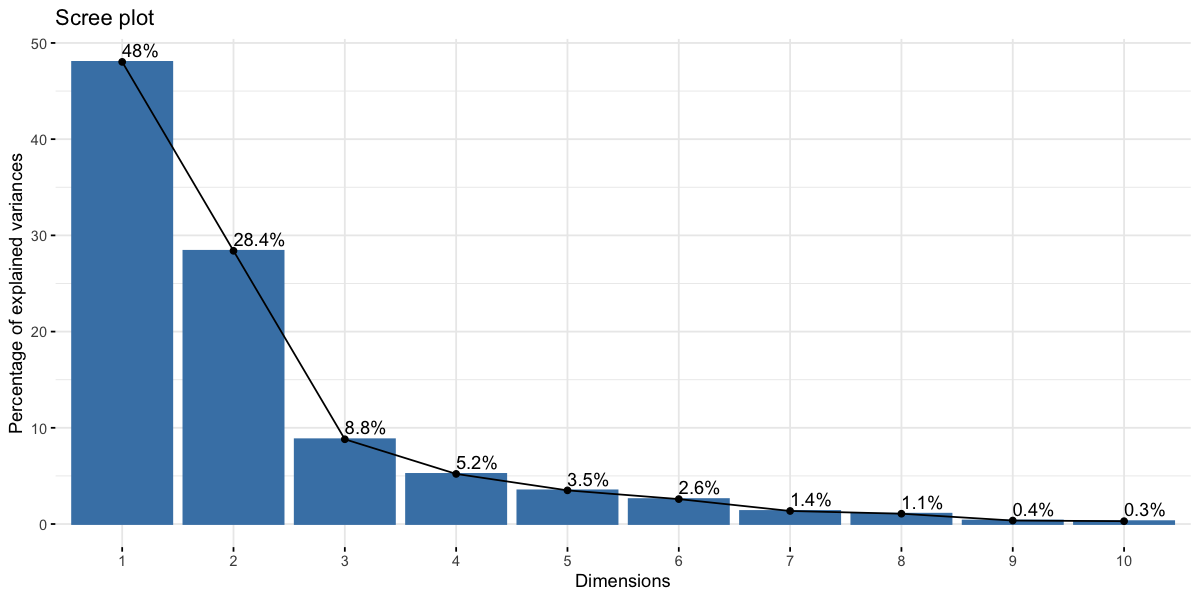

In [16]:
# PCA helps in identifying outlying samples for quality control and gives a feeling for the principal causes of 
# variation in a dataset

# Calculate principal components using transposed count data
pca <- prcomp(t(countdata))

options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(pca, addlabels = TRUE)

In [17]:
# Make dataframe for PCA plot generation using first two components and the sample name
pca_df <- data.frame(PC1 = pca$x[,1], PC2 = pca$x[,2], SampleID = colnames(countdata))

# Calculating percent of the variation that is captured by each principal component
pca_percent <- round(100*pca$sdev^2/sum(pca$sdev^2), 1)

# Organize dataframe so we can color our points by burn condition
pca_df <- pca_df %>% 
    separate(SampleID, into = c("SubjectNo", "Condensate", "Burn_Condition"), sep = "_", remove = FALSE)

head(pca_df)

,PC1,PC2,SampleID,SubjectNo,Condensate,Burn_Condition
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1_C_F,-3.3774986,2.5001195,1_C_F,1,C,F
2_C_F,-0.7519168,-0.3275656,2_C_F,2,C,F
3_C_F,-0.7091307,-2.2661781,3_C_F,3,C,F
4_C_F,-0.3868928,-1.6453079,4_C_F,4,C,F
6_C_F,0.6541925,1.4772253,6_C_F,6,C,F
2_C_S,1.0769099,-2.3635152,2_C_S,2,C,S


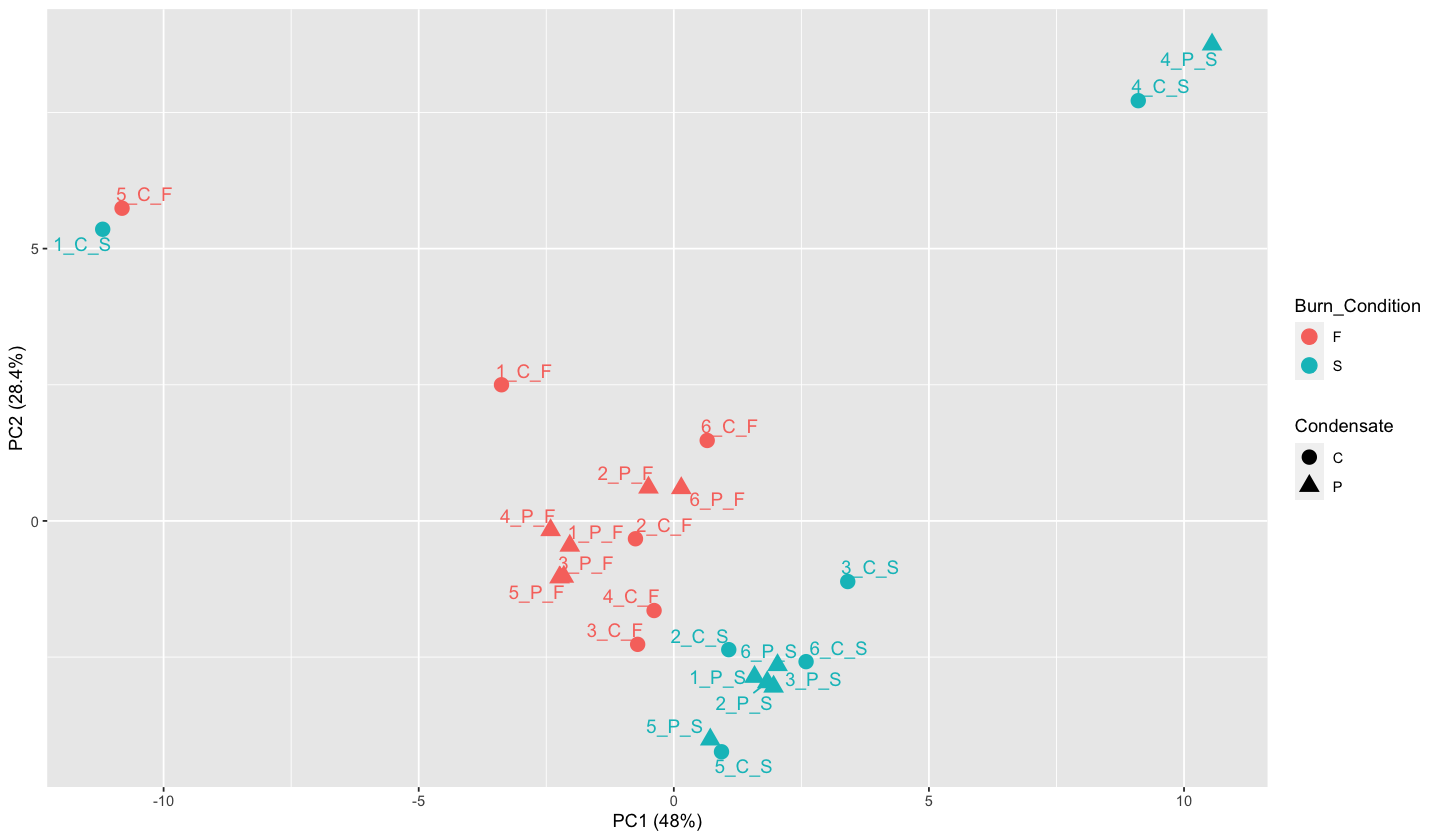

In [18]:
options(repr.plot.width=12, repr.plot.height=7) #changing size

# color by burn condition and condensate
ggplot(pca_df, aes(PC1, PC2, color = Burn_Condition, shape = Condensate)) +
  geom_point(size = 4) +
  geom_text_repel(aes(label = SampleID), size = 4) +
  labs(x = paste0("PC1 (",pca_percent[1],"%)"), y = paste0("PC2 (",pca_percent[2],"%)"))

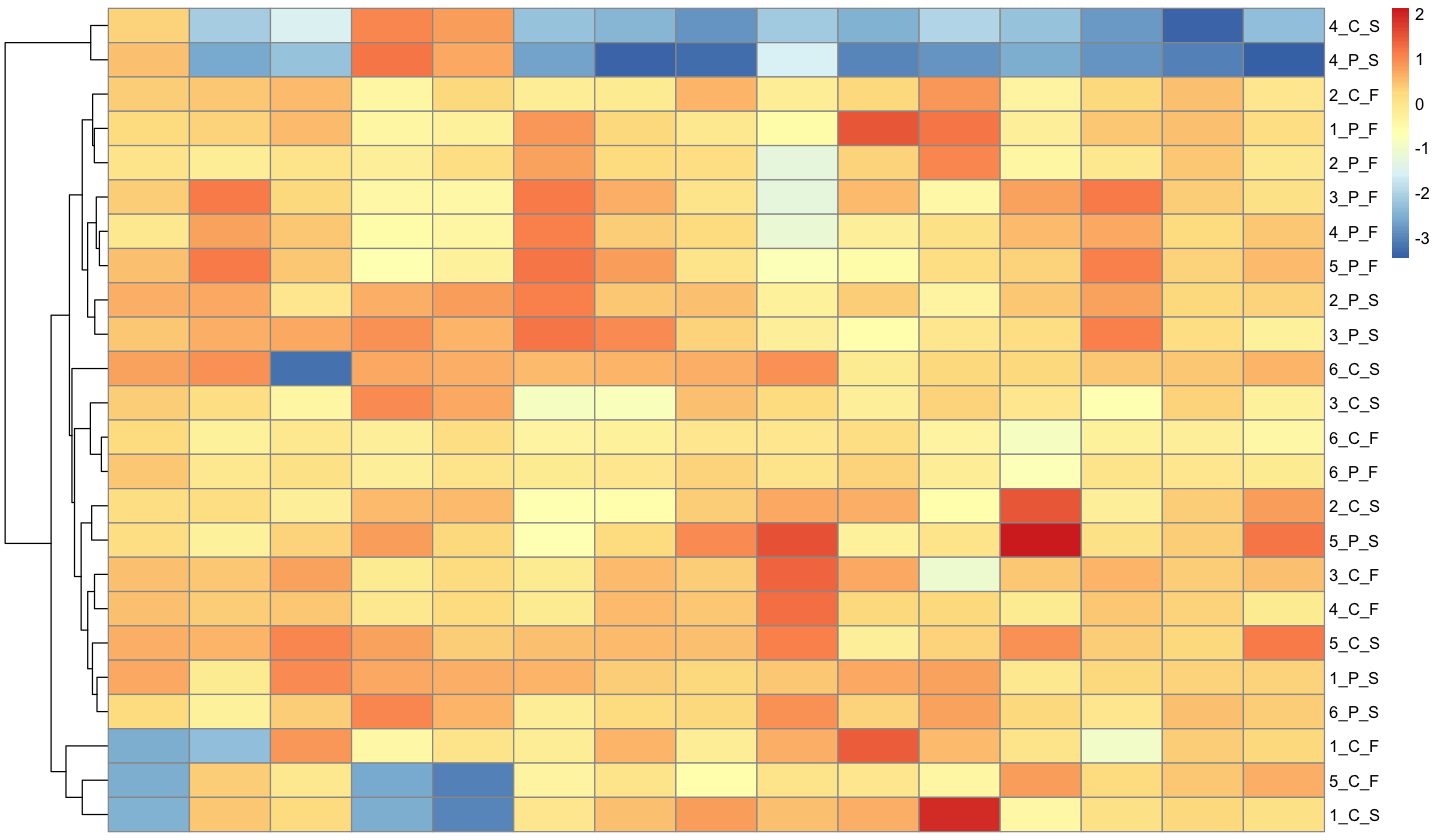

In [19]:
countdata_for_clustering <- t(countdata)

pheatmap(scale(countdata_for_clustering), 
         cluster_rows = TRUE, cluster_cols = FALSE, fontsize_col = 7, treeheight_row = 60, show_colnames = FALSE)

No sample outliers from PCA or hierarchical clustering. However, 4_P_S does look like an outlier in hierarchical clustering. SHOULD WE STILL BE NORMALIZING???

In [ ]:
# Set up our experiment using our RUV adjusted count and phenotype data.
# Our design indicates that our count data is dependent on the exposure condition 
# (groups variable) and our factor of unwanted variation, and we have specified 
# that there not be an intercept term through the use of '~0'

## CHANGE DESIGN TO INCLUDE SEX??
dds <- DESeqDataSetFromMatrix(countData = round(counts(ruv_set)), # Grabbing count data from the 'ruv_set' object
                              colData = pData(ruv_set), # Grabbing the phenotype data and corresponding factor of unwanted variation from the 'ruv_set' object
                              design = ~0 + groups + W_1) # Setting up the statistical formula (see below)

# Estimate size factors from the dds object that was just created as the experiment above
dds <- estimateSizeFactors(dds)
sizeFactors(dds)  # viewing the size factors